# Agricultural land object masks with SAM

This notebook shows how to segment objects from an image using the Segment Anything Model (SAM) with a few lines of code. Make sure you use GPU runtime for this notebook. 

## Prepare Working Directory

In [1]:
# Import the os module
import os

path = 'tmp/'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Current working directory: /home/ec2-user/SageMaker/ODP_Demo/tmp


## Import Libaray

In [2]:
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map & select observation area

In [3]:
m = leafmap.Map(center=[36.718522, -2.744180], zoom=15)
naip_url = 'https://www.ign.es/wms-inspire/pnoa-ma?'
m.add_wms_layer(
    url=naip_url,
    layers='OI.OrthoimageCoverage',
    name='Ortoimagen MA PNOA',
    attribution='PNOA',
    format='image/png',
    shown=True,
)
m.attribution_control=False
m

Map(center=[36.718522, -2.74418], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [4]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
    #print(bbox)
else:
    bbox = [-2.7434, 36.7088, -2.726, 36.7172]

## Download a sample image

In [5]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 01/35
Downloaded image 02/35
Downloaded image 03/35
Downloaded image 04/35
Downloaded image 05/35
Downloaded image 06/35
Downloaded image 07/35
Downloaded image 08/35
Downloaded image 09/35
Downloaded image 10/35
Downloaded image 11/35
Downloaded image 12/35
Downloaded image 13/35
Downloaded image 14/35
Downloaded image 15/35
Downloaded image 16/35
Downloaded image 17/35
Downloaded image 18/35
Downloaded image 19/35
Downloaded image 20/35
Downloaded image 21/35
Downloaded image 22/35
Downloaded image 23/35
Downloaded image 24/35
Downloaded image 25/35
Downloaded image 26/35
Downloaded image 27/35
Downloaded image 28/35
Downloaded image 29/35
Downloaded image 30/35
Downloaded image 31/35
Downloaded image 32/35
Downloaded image 33/35
Downloaded image 34/35
Downloaded image 35/35
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

In [8]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=None,
)

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [9]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

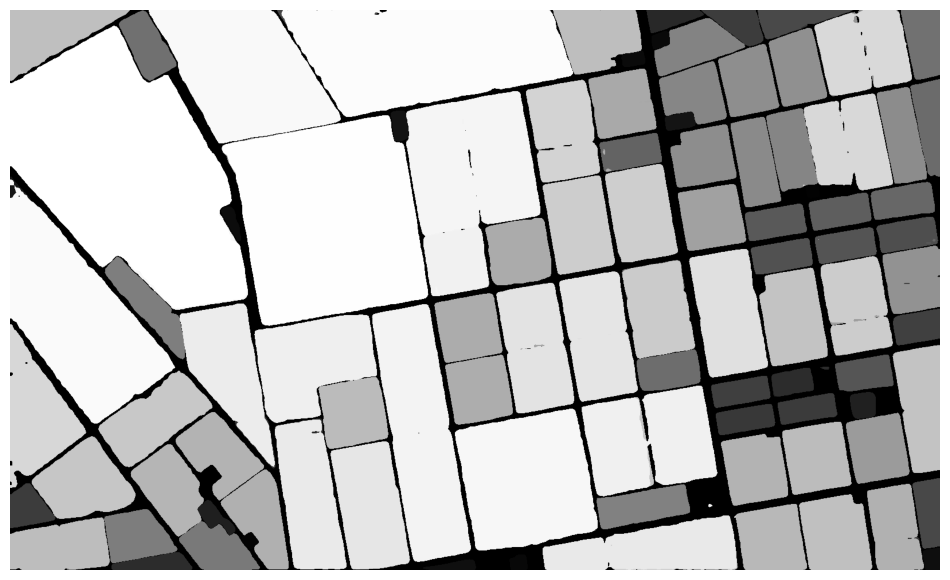

In [10]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

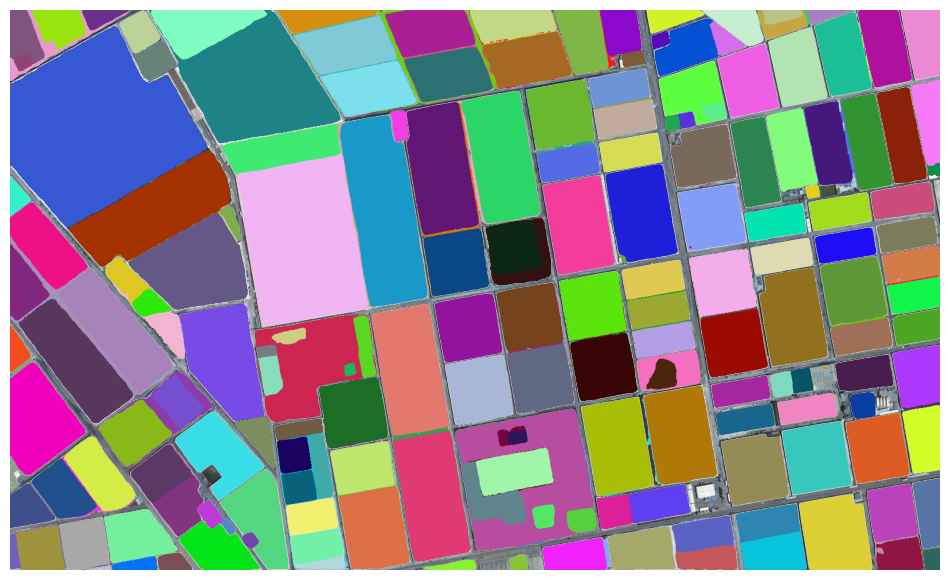

In [11]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

## Compare images with a slider.


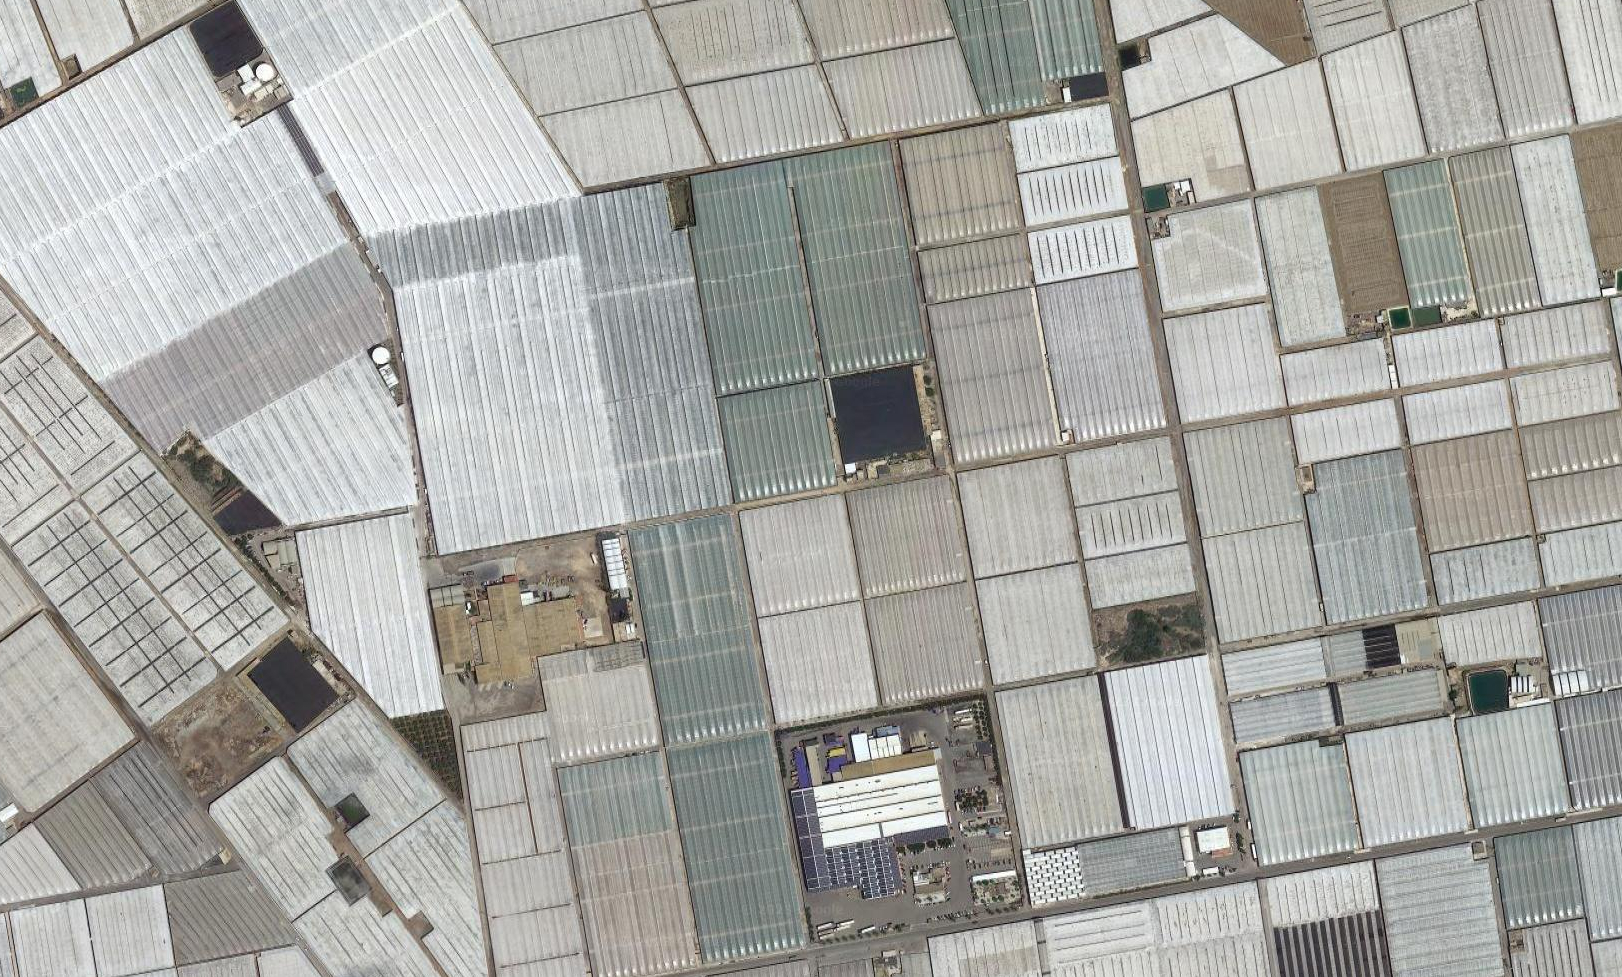
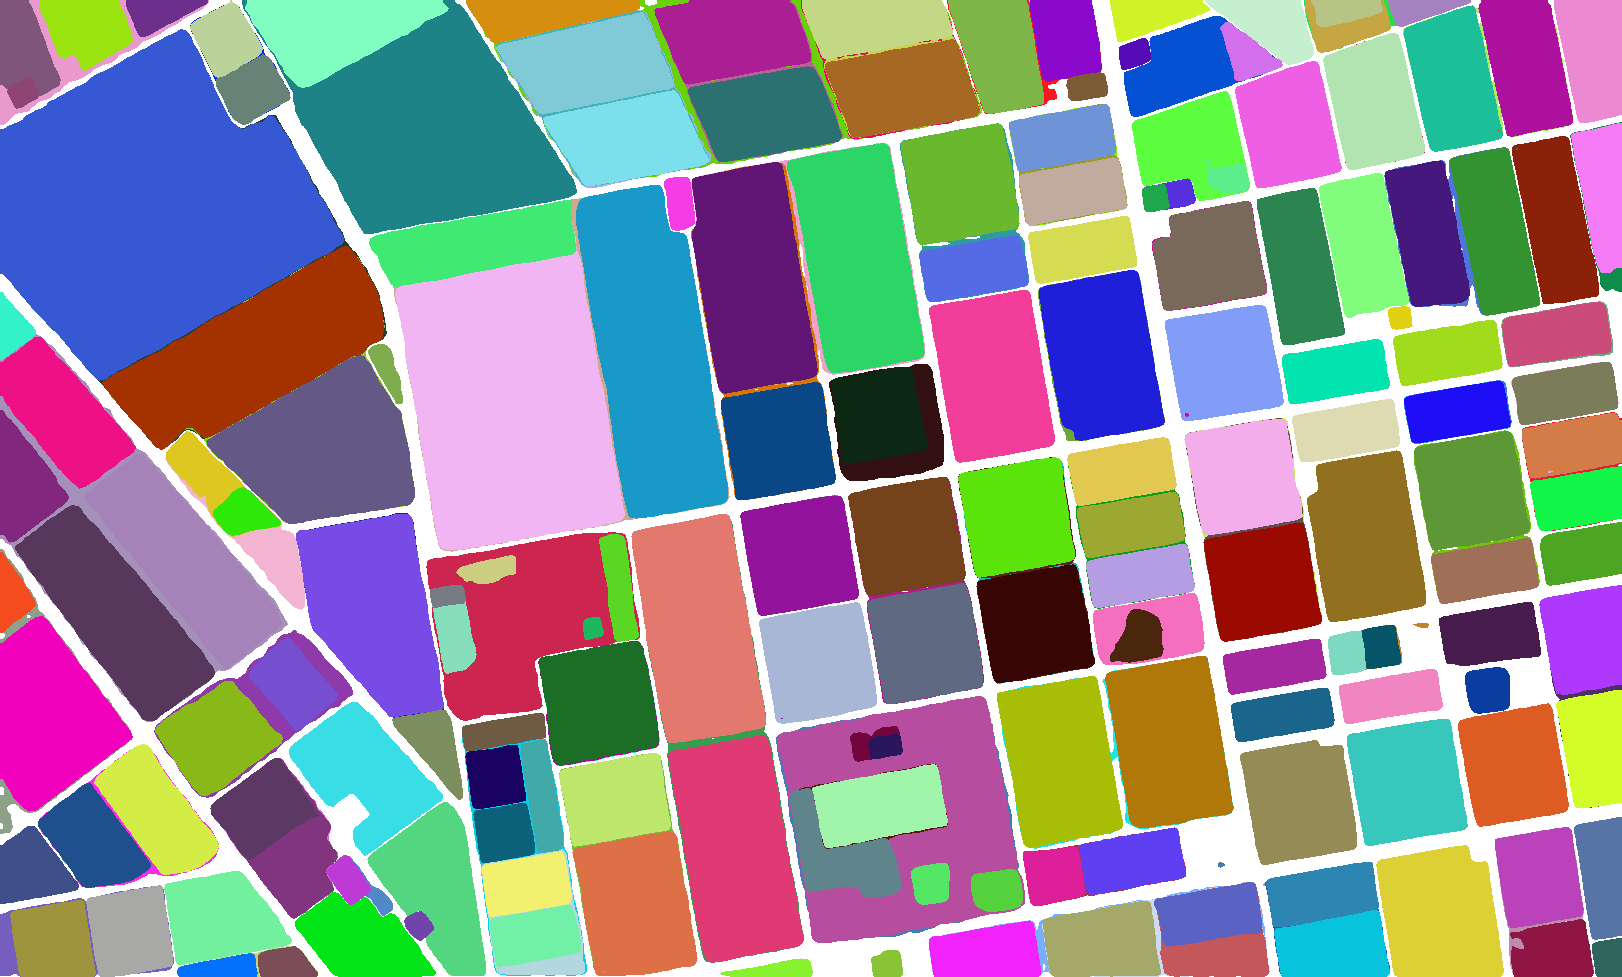

In [12]:
import leafmap

img1 = 'satellite.tif'
img2 = "annotations.tif"

leafmap.image_comparison(
    img1,
    img2,
    label1='Satellite Image',
    label2='Image Segmentation',
    starting_position=50,
    out_html='nongtian_comparison_1.html',
)

## Mask Output

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [13]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [14]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [15]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

In [16]:
sam.generate(image, output="masks2.tif", foreground=True)

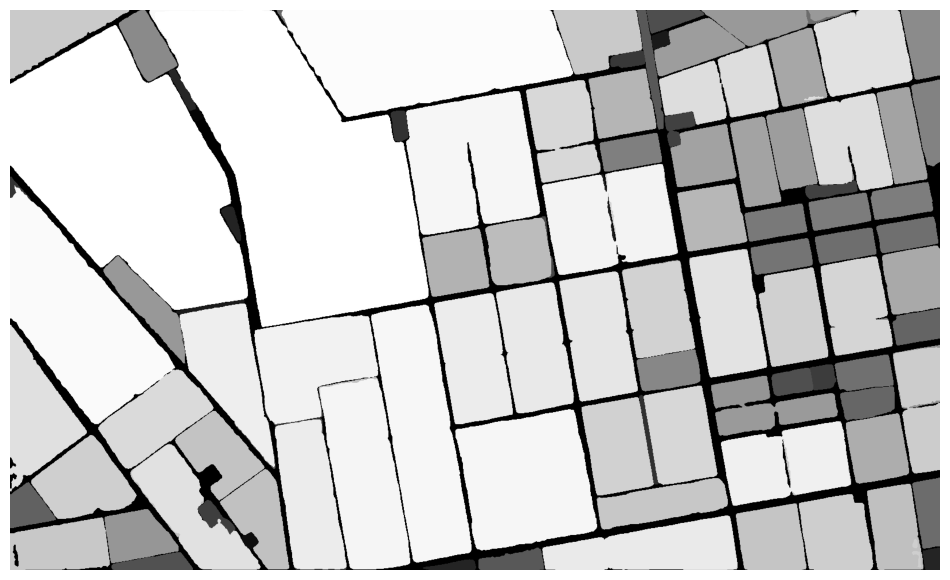

In [17]:
sam.show_masks(cmap="binary_r")

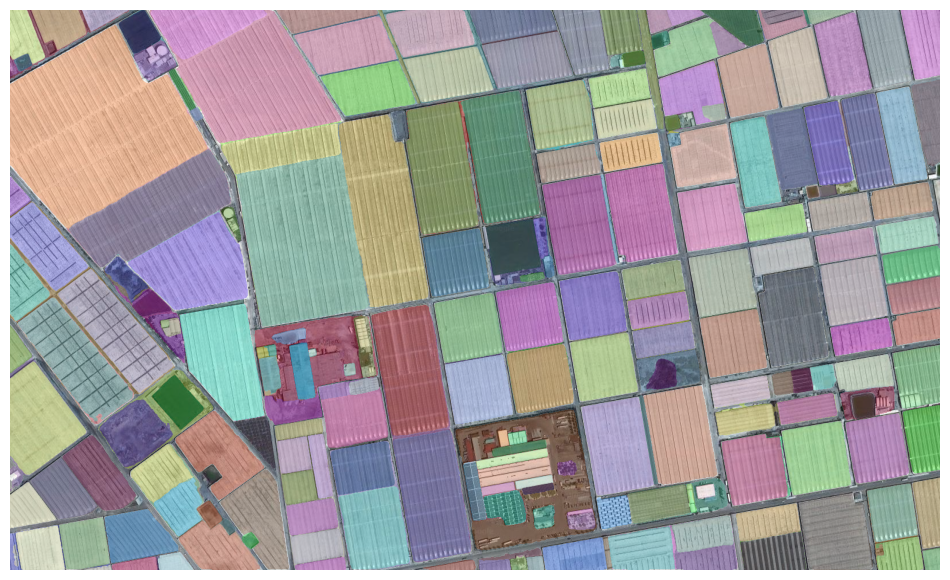

In [18]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

## Polygonize the raster data

Save the segmentation results as a GeoPackage file. You can also save the segmentation results as any vector data format supported by GeoPandas.

In [19]:
mask2 = "masks2.tif"

In [20]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask2, vector, simplify_tolerance=None)

In [21]:
shapefile = "segment.shp"
sam.tiff_to_vector(mask2, shapefile)

In [22]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(center=[36.718522, -2.74418], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

## Outputs Reference: 
Reference in GIF format pulled from imgur.com.

![](https://imgur.com/5BEuU62.gif)